## Transformer
10.6.2节中⽐较了卷积神经⽹络（CNN）、循环神经⽹络（RNN）和⾃注意⼒（self-attention）。值得注意的是，
⾃注意⼒同时具有并⾏计算和最短的最⼤路径⻓度这两个优势。因此，使⽤⾃注意⼒来设计深度架构是很有
吸引⼒的。对⽐之前仍然依赖循环神经⽹络实现输⼊表⽰的⾃注意⼒模型 (Cheng et al., 2016, Lin et al., 2017,
Paulus et al., 2017)，Transformer模型完全基于注意⼒机制，没有任何卷积层或循环神经⽹络层 (Vaswani et
al., 2017)。尽管Transformer最初是应⽤于在⽂本数据上的序列到序列学习，但现在已经推⼴到各种现代的
深度学习中，例如语⾔、视觉、语⾳和强化学习领域。

### 模型
Transformer作为编码器－解码器架构的⼀个实例，其整体架构图在 图10.7.1中展⽰。正如所⻅到的，Transformer是由编码器和解码器组成的。与图10.4.1中基于Bahdanau注意⼒实现的序列到序列的学习相⽐，Transformer的编码器和解码器是基于⾃注意⼒的模块叠加⽽成的，源（输⼊）序列和⽬标（输出）序列的嵌⼊（embedding）表⽰将加上位置编码（positional encoding），再分别输⼊到编码器和解码器中。

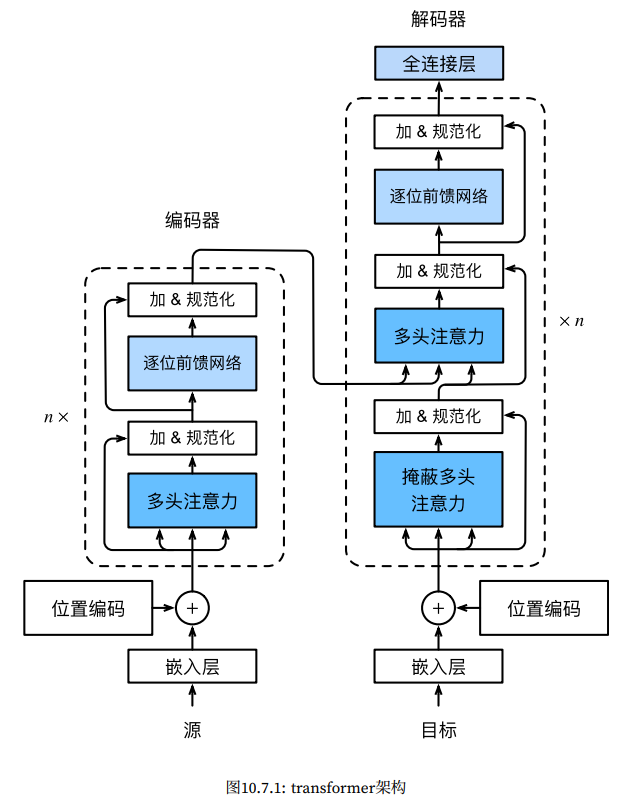

图 图10.7.1中概述了Transformer的架构。从宏观⻆度来看，Transformer的编码器是由多个相同的层叠加⽽
成的，每个层都有两个⼦层（⼦层表⽰为sublayer）。第⼀个⼦层是多头⾃注意⼒（multi-head self-attention）
汇聚；第⼆个⼦层是基于位置的前馈⽹络（positionwise feed-forward network）。具体来说，在计算编码器
的⾃注意⼒时，查询、键和值都来⾃前⼀个编码器层的输出。受 7.6节中残差⽹络的启发，每个⼦层都采⽤
了残差连接（residual connection）。在Transformer中，对于序列中任何位置的任何输⼊x ∈ R
d，都要求满⾜sublayer(x) ∈ Rd，以便残差连接满⾜x + sublayer(x) ∈ Rd。在残差连接的加法计算之后，紧接着应⽤层
规范化（layer normalization）(Ba et al., 2016)。因此，输⼊序列对应的每个位置，Transformer编码器都将
输出⼀个d维表⽰向量。

Transformer解码器也是由多个相同的层叠加⽽成的，并且层中使⽤了残差连接和层规范化。除了编码器中
描述的两个⼦层之外，解码器还在这两个⼦层之间插⼊了第三个⼦层，称为编码器－解码器注意⼒（encoder-decoder attention）层。
在编码器－解码器注意⼒中，查询来⾃前⼀个解码器层的输出，⽽键和值来⾃整个
编码器的输出。在解码器⾃注意⼒中，查询、键和值都来⾃上⼀个解码器层的输出。但是，解码器中的每个位
置只能考虑该位置之前的所有位置。这种掩蔽（masked）注意⼒保留了⾃回归（auto-regressive）属性，确
保预测仅依赖于已⽣成的输出词元。

在 此 之 前 已 经 描 述 并 实 现 了 基 于 缩 放 点 积 多 头 注 意 ⼒ 10.5节和 位 置 编 码 10.6.3节。 接 下 来 将 实
现Transformer模型的剩余部分。


In [119]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


### 基于位置的前馈网络
基于位置的前馈⽹络对序列中的所有位置的表⽰进⾏变换时使⽤的是同⼀个多层感知机（MLP），这就是称
前馈⽹络是基于位置的（positionwise）的原因。在下⾯的实现中，输⼊X的形状（批量⼤⼩，时间步数或序列
⻓度，隐单元数或特征维度）将被⼀个两层的感知机转换成形状为（批量⼤⼩，时间步数，ffn_num_outputs）
的输出张量。




In [120]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈⽹络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


下⾯的例⼦显⽰，改变张量的最⾥层维度的尺⼨，会改变成基于位置的前馈⽹络的输出尺⼨。因为⽤同⼀个
多层感知机对所有位置上的输⼊进⾏变换，所以当所有这些位置的输⼊相同时，它们的输出也是相同的。


In [121]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()


PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=8, bias=True)
)

In [122]:
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.0268, -0.0633,  0.3822, -0.1761, -0.4391, -0.1917,  0.3136, -0.4938],
        [ 0.0268, -0.0633,  0.3822, -0.1761, -0.4391, -0.1917,  0.3136, -0.4938],
        [ 0.0268, -0.0633,  0.3822, -0.1761, -0.4391, -0.1917,  0.3136, -0.4938]],
       grad_fn=<SelectBackward0>)

### 残差连接和层规范化
现在让我们关注 图10.7.1中的加法和规范化（add&norm）组件。正如在本节开头所述，这是由残差连接和
紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

7.5节中解释了在⼀个⼩批量的样本内基于批量规范化对数据进⾏重新中⼼化和重新缩放的调整。层规范化
和批量规范化的⽬标相同，但层规范化是基于特征维度进⾏规范化。尽管批量规范化在计算机视觉中被⼴泛
应⽤，但在⾃然语⾔处理任务中（输⼊通常是变⻓序列）批量规范化通常不如层规范化的效果好。

以下代码对⽐不同维度的层规范化和批量规范化的效果。


In [123]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和⽅差
print(X)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))


tensor([[1., 2.],
        [2., 3.]])
layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以使⽤残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化⽅法使⽤。

In [124]:
#@save
class AddNorm(nn.Module):
    """残差连接后进⾏层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输⼊的形状相同，以便加法操作后输出张量的形状相同。

In [125]:
add_norm = AddNorm([3, 4], 0.5)
print(add_norm.eval())
print(add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))))
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>)


torch.Size([2, 3, 4])

### 编码器
有了组成Transformer编码器的基础组件，现在可以先实现编码器中的⼀个层。下⾯的EncoderBlock类包含
两个⼦层：多头⾃注意⼒和基于位置的前馈⽹络，这两个⼦层都使⽤了残差连接和紧随的层规范化。

In [126]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


正如从代码中所看到的，Transformer编码器中的任何层都不会改变其输⼊的形状。


In [127]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
print(encoder_blk.eval())
encoder_blk(X, valid_lens).shape

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)


torch.Size([2, 100, 24])

下⾯实现的Transformer编码器的代码中，堆叠了num_layers个EncoderBlock类的实例。由于这⾥使⽤的是
值范围在−1和1之间的固定位置编码，因此通过学习得到的输⼊的嵌⼊表⽰的值需要先乘以嵌⼊维度的平⽅
根进⾏重新缩放，然后再与位置编码相加。


In [128]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌⼊值乘以嵌⼊维度的平⽅根进⾏缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X
    




下⾯我们指定了超参数来创建⼀个两层的Transformer编码器。Transformer编码器输出的形状是（批量⼤
⼩，时间步数⽬，num_hiddens）。

In [129]:
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建⼀个⾜够⻓的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [130]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()

TransformerEncoder(
  (embedding): Embedding(200, 24)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (W_q): Linear(in_features=24, out_features=24, bias=False)
        (W_k): Linear(in_features=24, out_features=24, bias=False)
        (W_v): Linear(in_features=24, out_features=24, bias=False)
        (W_o): Linear(in_features=24, out_features=24, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.5, inplace=False)
        (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=24, out_features=48, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=48, out_features=24, bias=True)
      )
      (addnorm2): AddNorm(
        (d

### 解码器
如 图10.7.1所⽰，Transformer解码器也是由多个相同的层组成。在DecoderBlock类中实现的每个层包含了三
个⼦层：解码器⾃注意⼒、“编码器-解码器”注意⼒和基于位置的前馈⽹络。这些⼦层也都被残差连接和紧
随的层规范化围绕。

正如在本节前⾯所述，在掩蔽多头解码器⾃注意⼒层（第⼀个⼦层）中，查询、键和值都来⾃上⼀个解码器
层的输出。关于序列到序列模型（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时
间步）的词元都是已知的；然⽽，在预测阶段，其输出序列的词元是逐个⽣成的。因此，在任何解码器时间
步中，只有⽣成的词元才能⽤于解码器的⾃注意⼒计算中。为了在解码器中保留⾃回归的属性，其掩蔽⾃注
意⼒设定了参数dec_valid_lens，以便任何查询都只会与解码器中所有已经⽣成词元的位置（即直到该查询
位置为⽌）进⾏注意⼒计算。


In [131]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同⼀时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元⼀个接着⼀个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表⽰
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每⼀⾏是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        # ⾃注意⼒
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意⼒。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


为了便于在“编码器－解码器”注意⼒中进⾏缩放点积计算和残差连接中进⾏加法计算，编码器和解码器的
特征维度都是num_hiddens。


In [132]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由num_layers个DecoderBlock实例组成的完整的Transformer解码器。最后，通过⼀个全连
接层计算所有vocab_size个可能的输出词元的预测值。解码器的⾃注意⼒权重和编码器解码器注意⼒权重都
被存储下来，⽅便⽇后可视化的需要。

In [133]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意⼒机制解码器的基本接⼝"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [134]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)

        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
        def init_state(self, enc_outputs, enc_valid_lens, *args):
            return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
        
        def forward(self, X, state):
            X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
            self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
            for i, blk in enumerate(self.blks):
                X, state = blk(X, state)
                # 解码器⾃注意⼒权重
                self._attention_weights[0][
                    i] = blk.attention1.attention.attention_weights
                # “编码器－解码器”⾃注意⼒权重
                self._attention_weights[1][
                    i] = blk.attention2.attention.attention_weights
            return self.dense(X), state
        
        @property
        def attention_weights(self):
            return self._attention_weights


### 训练
依照Transformer架构来实例化编码器－解码器模型。在这⾥，指定Transformer的编码器和解码器都是2层，
都使⽤4头注意⼒。与 9.7.4节类似，为了进⾏序列到序列的学习，下⾯在“英语－法语”机器翻译数据集上
训练Transformer模型。


In [135]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [136]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward() # 损失函数的标量进⾏“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

In [138]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
#train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


## 小结
* Transformer是编码器－解码器架构的⼀个实践，尽管在实际情况中编码器或解码器可以单独使⽤。
* 在Transformer中，多头⾃注意⼒⽤于表⽰输⼊序列和输出序列，不过解码器必须通过掩蔽机制来保留⾃回归属性。
* Transformer中的残差连接和层规范化是训练⾮常深度模型的重要⼯具。
* Transformer模型中基于位置的前馈⽹络使⽤同⼀个多层感知机，作⽤是对所有序列位置的表⽰进⾏转换。
